In [24]:
%pylab inline
from lib import price_utils
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
reload(price_utils)
pd.options.display.float_format = '£{:,.2f}'.format


month = '2016-09-01'

Populating the interactive namespace from numpy and matplotlib


# Top ccg-presentation savings

The SQL for this is abstracted into the `price_utils` library, q.v. for details.

We normalise prescriptions to their generic equivalent (where possible), and exclude specials.

The following is sorted by possible savings at the top decile. It tells us that CCG 03C (NHS Leeds West) had the single biggest saving opportunity: to save £13,500 on its purchase of 60 Sucralfate Enemas. It paid £238 per dose, when the lowest decile paid £12 per dose.

In [21]:
top_1000_ccg = price_utils.get_savings(group_by='ccg', month=month, limit=1000)

In [22]:
top_1000_ccg.head()

,bnf_presentation,pct,generic_presentation,category,brand_count,lowest_decile,quantity,price_per_dose,possible_savings
0,Influenza_Vac Inact 0.5ml Pfs,13T,1404000H0AAAFAF,NP8,4,5.850000,25993,7.735321,49005.16
1,Fluticasone/Salmeterol_Inh 250/25mcg120D,13P,0302000N0AABGBG,C,3,44.610000,3170,59.104732,45948.30
2,Glycopyrronium Brom_Inh Cap 55mcg + Dev,06M,0301020S0AAAAAA,C,2,0.916667,23403,2.521658,37561.61
3,Fluticasone/Salmeterol_Inh 250/25mcg120D,01H,0302000N0AABGBG,C,3,44.610000,2531,57.864334,33546.72
4,Fluticasone/Salmeterol_Inh 250/25mcg120D,09G,0302000N0AABGBG,C,3,44.610000,2221,59.419743,32892.44


How do the savings break down by Tariff Part VIII?

In [25]:
top_1000_ccg.to_csv("ccgs-%s.csv" % month)
top_1000_ccg.groupby('category')['possible_savings'].sum()

category
A      £286,456.24 
C     £6,523,860.35
M      £649,525.26 
NP8   £1,977,337.43
Name: possible_savings, dtype: float64

## Grouped by CCG

The same data as above, but grouped by CCG

In [26]:
len(top_1000_ccg[top_1000_ccg.possible_savings < 0])


0

In [29]:
by_ccg = top_1000_ccg.groupby('pct')['possible_savings'] \
  .agg({'Count': 'count', 'Total savings': 'sum'}).sort_values('Total savings', ascending=False)
by_ccg.head()

,Count,Total savings
pct,,
11J,22,"£291,403.96"
99P,20,"£289,321.76"
13P,19,"£252,858.15"
01H,19,"£216,677.38"
11N,20,"£210,712.53"


In [30]:
by_ccg['Total savings'].sum()

9437179.2835492939

## Just focusing on Rich's CCG

In [31]:
by_ccg.loc('savings_presentations_pct')['99P']

Count               £20.00 
Total savings   £289,321.76
Name: 99P, dtype: float64

In [32]:
asd = price_utils.get_savings(for_entity='99P', month=month, limit=None)

In [33]:
asd.sort_values('possible_savings', ascending=False)

,bnf_presentation,pct,generic_presentation,category,brand_count,lowest_decile,quantity,price_per_dose,possible_savings
0,Budesonide/Formoterol Inh B/A 200/6(120D,99P,0302000K0AAAMAM,C,3,£29.97,5042,£36.47,"£32,770.43"
1,Pregabalin_Cap 300mg,99P,0408010AEAAAGAG,C,3,£0.80,93796,£1.12,"£29,241.90"
2,Pregabalin_Cap 150mg,99P,0408010AEAAAEAE,C,3,£0.80,89637,£1.11,"£27,266.16"
3,Fluticasone/Salmeterol_Inh 125/25mcg120D,99P,0302000N0AABFBF,C,3,£26.25,3212,£34.60,"£26,836.25"
4,Budesonide/Formoterol Inh B/A 400/12(60D,99P,0302000K0AAAUAU,C,3,£29.97,3815,£36.32,"£24,210.45"
5,Pregabalin_Cap 75mg,99P,0408010AEAAACAC,C,3,£0.80,81763,£1.09,"£23,295.90"
6,Influenza_Vac Inact 0.5ml Pfs,99P,1404000H0AAAFAF,NP8,7,£5.85,35736,£6.43,"£20,707.54"
7,Beclomet Diprop_Inha 100mcg (200 D) CFF,99P,0302000C0AABFBF,NP8,3,£7.42,5999,£10.77,"£20,108.66"
8,Pregabalin_Cap 50mg,99P,0408010AEAAABAB,C,3,£0.80,57646,£1.09,"£16,673.08"
9,Methocarbamol_Tab 750mg,99P,1002020S0AAABAB,A,2,£0.13,43623,£0.50,"£16,082.10"


In [34]:
# Save it to a cSV

asd.to_csv("99P-full-%s.csv" % month)

# Same thing for practices

In [35]:
top_1000_practice = price_utils.get_savings(group_by='practice',month=month, limit=1000)

In [36]:
top_1000_practice.head()


,bnf_presentation,practice,pct,generic_presentation,category,brand_count,lowest_decile,quantity,price_per_dose,possible_savings
0,Sucralfate_Enem 2g In 50ml,B86030,03C,0107010S0AAAGAG,NP8,1,£12.17,60,£256.50,"£14,659.83"
1,"Dalteparin Sod_Inj 25,000u/ml 0.72ml Pfs",K84055,10Q,0208010L0AAAIAI,NP8,1,£10.16,110,£137.41,"£13,996.85"
2,Sod Phenylbut_Liq Spec 1.25g/5ml,J82034,11A,0908010P0AAAEAE,NP8,1,£1.09,2500,£5.56,"£11,187.72"
3,None,E83638,07M,0908010S0AAACAC,NP8,1,£22.91,400,£49.99,"£10,831.68"
4,Melatonin_Tab 3mg,H82016,09G,0401010ADAABPBP,NP8,2,£0.75,552,£19.26,"£10,219.00"


In [37]:

top_1000_practice.to_csv("practices-%s.csv" % month)

# What is the distribution of the easiest cost savings?

For each practice, compute and sum its top three savings, then plot these in a histogram.

In [38]:
reload(price_utils)
top_10 = price_utils.top_savings_per_entity(top_n=10, entity='practice')

In [39]:
top_10.describe()

,top_savings_sum
count,"£7,637.00"
mean,"£2,527.14"
std,"£1,708.07"
min,£0.00
25%,"£1,367.73"
50%,"£2,173.39"
75%,"£3,293.78"
max,"£20,885.71"


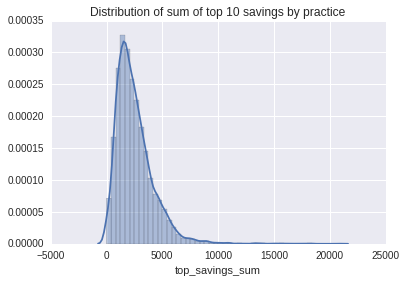

In [40]:
sns.distplot(top_10.top_savings_sum)
plt.title("Distribution of sum of top 10 savings by practice")
plt.show()

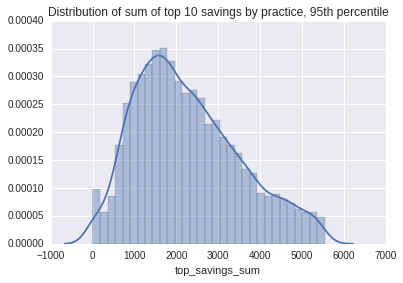

In [41]:
asd = top_10[top_10.top_savings_sum < top_10.top_savings_sum.quantile(.95)]
g = sns.distplot(asd.top_savings_sum)
plt.title("Distribution of sum of top 10 savings by practice, 95th percentile")
plt.show()

In [42]:
top_10_pct = price_utils.top_savings_per_entity(top_n=10, entity='pct')

In [43]:
top_10_pct.describe()

,top_savings_sum
count,£213.00
mean,"£8,115.55"
std,"£3,380.31"
min,£39.53
25%,"£6,055.19"
50%,"£7,508.52"
75%,"£9,312.40"
max,"£22,355.28"


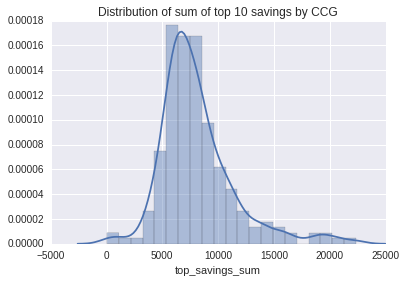

In [44]:
sns.distplot(top_10_pct.top_savings_sum)
plt.title("Distribution of sum of top 10 savings by CCG")
plt.show()

In [51]:
reload(price_utils)
top_1000_product = price_utils.get_savings(group_by='product',month=month, limit=1000)


In [52]:
top_1000_product.head(30)

,bnf_presentation,generic_presentation,category,brand_count,lowest_decile,quantity,price_per_dose,possible_savings
0,Fluticasone/Salmeterol_Inh 250/25mcg120D,0302000N0AABGBG,C,3,£44.61,158950,£56.36,"£1,866,927.90"
1,Pregabalin_Cap 75mg,0408010AEAAACAC,C,5,£0.81,5035691,£1.13,"£1,615,982.91"
2,Influenza_Vac Inact 0.5ml Pfs,1404000H0AAAFAF,NP8,11,£5.85,2055110,£6.62,"£1,588,060.62"
3,Budesonide/Formoterol Inh B/A 200/6(120D,0302000K0AAAMAM,C,3,£29.97,225338,£36.47,"£1,465,282.03"
4,Budesonide/Formoterol Inh B/A 400/12(60D,0302000K0AAAUAU,C,3,£29.97,153858,£36.16,"£952,534.52"
5,Fluticasone/Salmeterol_Inh 125/25mcg120D,0302000N0AABFBF,C,3,£26.25,133039,£33.15,"£917,909.75"
6,Metformin HCl_Tab 500mg M/R,0601022B0AAASAS,C,8,£0.06,27064169,£0.09,"£788,899.21"
7,Glycopyrronium Brom_Inh Cap 55mcg + Dev,0301020S0AAAAAA,C,2,£0.92,342685,£2.93,"£691,464.79"
8,Beclomet Diprop_Inha 100mcg (200 D) CFF,0302000C0AABFBF,NP8,3,£7.42,358653,£9.17,"£625,914.27"
9,Venlafaxine_Cap 150mg M/R,0403040W0AAAEAE,C,12,£0.14,1400156,£0.53,"£549,354.40"


In [2]:
import peakutils
from peakutils.plot import plot as pplot


sql = """  SELECT
    *
  FROM
    ebmdatalab.tmp_eu.prescribing_sept
  WHERE
    bnf_code = '0301020S0AAAAAA'"""
df = pd.io.gbq.read_gbq(sql, project_id="ebmdatalab", verbose=False, dialect='standard')

In [3]:
df['ppq'] = df['actual_cost'] / df['quantity']
df = df.sort_values('ppq')

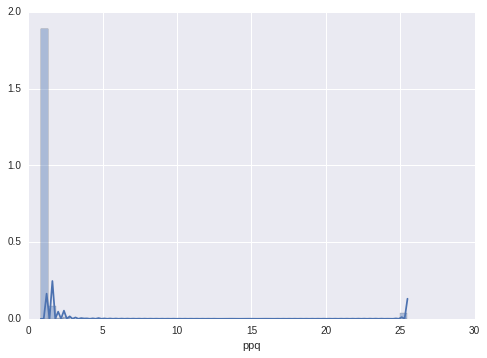

In [4]:
sns.distplot(df['ppq'])


In [62]:
# http://pythonhosted.org/PeakUtils/tutorial_a.html#estimating-and-removing-the-baseline
#list(df['ppq'])
y, bin_edges = numpy.histogram(df['ppq'], range=(-5, 40))

array([   0, 2121,    1,    0,    0,    0,   41,    0,    0,    0])

In [67]:
peakutils.indexes(y, thres=0.00001, min_dist=0.000001)

array([1, 6])

In [49]:
from scipy import signal
signal.find_peaks_cwt(y, np.arange(1,10))


[1]

In [50]:
numpy.r_[True, y[1:] < y[:-1]] & numpy.r_[y[:-1] < y[1:], True]

array([False, False, False, False, False, False, False, False, False, False], dtype=bool)

In [51]:
import numpy as np
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology

def detect_local_minima(arr):
    # http://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
    neighborhood = morphology.generate_binary_structure(len(arr.shape),2)
    # apply the local minimum filter; all locations of minimum value 
    # in their neighborhood are set to 1
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
    local_min = (filters.minimum_filter(arr, footprint=neighborhood)==arr)
    # local_min is a mask that contains the peaks we are 
    # looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask.
    # 
    # we create the mask of the background
    background = (arr==0)
    # 
    # a little technicality: we must erode the background in order to 
    # successfully subtract it from local_min, otherwise a line will 
    # appear along the background border (artifact of the local minimum filter)
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    # 
    # we obtain the final mask, containing only peaks, 
    # by removing the background from the local_min mask
    detected_minima = local_min - eroded_background
    return np.where(detected_minima)       

In [52]:
detect_local_minima(y)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:35: DeprecationWarning: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.


(array([2, 8]),)

In [61]:
peakutils.indexes(y, thres=0.5, min_dist=1)
y_with_zero = 

array([], dtype=int64)